In [406]:
import numpy as np
from scipy.stats import iqr
import dill
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import data_visualization as dv
import copy
import numba as nb
import time
import xarray as xr

import read_data_functions as rdf
import plot_functions as pf
import Optimal_Stopping_Object as oso
from initializer import InitialThangs
from pathlib import Path
from Subject_Object_v3 import perc

np.set_printoptions(precision=3)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notebook Description

- After 6/26/23 Discussion with Josh, we decided to not do the fitting movement onset time (sanity check) that I had been doing before.
- Instead, we are going to compare three different optimal models
    1. Switch cost doesn't exist at all
    2. Switch cost exists and is accounted for by optimal decision maker
       - Use True Models optimal decision time with true model output arrays
    3. Switch cost exists and is not accounted for by optimal decision maker
       - Use Expected Models optimal decision Time (should be later than True Model) with true model output arrays
       -
- metric_type will always be "optimal" for this entire script (aka there is NO fitting to experimental data)

- INSTEAD, we are fitting the gamble delay and uncertainty that spits out the data
   - If this fitting procedure can perfectly match the data, then we will have captured why people are making indecisions
   - If not there is something else (SEE ALTERED REWARD FITTING JUPYTER NOTEBOOK)


## Outline

# Initial Thangs


In [407]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# SELECT EXPERIMENT
experiment = "Exp1"

# Get path and save path 
LOAD_PATH = Path(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
it = InitialThangs(experiment)

# Pickle Data


In [408]:
group = rdf.generate_subject_object_v3(experiment,)

# Create Model


Set inputs for model

In [409]:
if experiment == "Exp1":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.reaction_times, axis=1)) - 15
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=1))

elif experiment == "Exp2":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.exp2_react_gamble_reaction_time_split('react','only'), axis=1)) - 30
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.movement_metrics.movement_times('task'), axis=2), axis=0)) # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.movement_metrics.movement_times('task'), axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.movement_metrics.coincidence_reach_time, axis=1))] * it.num_blocks)
perc_wins_both_reach = np.nanmean(group.score_metrics.wins_when_both_reach(perc=True), axis=0)
guess_sd             = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.react_guess_movement_onset_times('guess'), axis=2), axis=0)
agent_sds            = np.nanmean(np.nanstd(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]
agent_means          = np.nanmean(np.nanmean(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]

#* Set win, incorrect, indecision reward if messing around with beta parameters
win_reward = 1.0
indecision_cost = 0.0
incorrect_cost = 0.0


 Set the model fitting parameters

In [410]:
if True:
    free_params_init = {
        "gamble_switch_delay": 0,
        "gamble_switch_sd": 0,
    }
    # targets = np.array(
    #     [np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2),axis=0),
    #     np.nanmedian(group.player_perc_wins,axis=0)/100,
    #     np.nanmedian(group.player_perc_incorrects,axis=0)/100,
    #     np.nanmedian(group.player_perc_indecisions,axis=0)/100,
    #     ]
    # )
    # metric_keys = ['wtd_leave_time','prob_win','prob_incorrect','prob_indecision']
    # group.predict_stopping_times(model_known_switch.inputs.gamble_delay["true"])
    behavior_targets = np.array(
        [
            [np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0)],
            [np.nanmedian(iqr(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0)],
        ]
    )
    behavior_metric_keys = ["wtd_leave_time", "wtd_leave_time_iqr"]

    results_targets = np.array([[np.nanmedian(group.score_metrics.score_metric('indecisions')/it.num_blocks, axis=0)]])
    results_metric_keys = ["prob_indecision"]

In [411]:
run_numba_quickly = oso.ModelConstructor(
     experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=5,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds= agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd  =np.array([rt_sd, rt_sd]),
    movement_sd  =np.array([mt_sd, mt_sd]),
    timing_sd    =np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    gamble_switch_delay=np.array([[0, 0]]).T, # Designed like this for broadcasting reasons
    gamble_switch_sd=np.array([[0, 0]]).T,
    electromechanical_delay=np.array([[50, 50]]).T,
    electromechanical_sd=np.array([[10, 10]]).T,
    switch_cost_exists=False,
    expected=False,
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)

Run model without switch cost

In [412]:
# Switch cost is the switch delay and the switch sd
# In this case we 
model_no_switch = oso.ModelConstructor(
     experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds= agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd  =np.array([rt_sd, rt_sd]),
    movement_sd  =np.array([mt_sd, mt_sd]),
    timing_sd    =np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    gamble_switch_delay=np.array([[0, 0]]).T, # Designed like this for broadcasting reasons
    gamble_switch_sd=np.array([[0, 0]]).T,
    electromechanical_delay=np.array([[50, 50]]).T,
    electromechanical_sd=np.array([[10, 10]]).T,
    switch_cost_exists=False,
    expected=False,
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)


Run model and fit the switch cost

In [415]:
# * Run true model and fit the gamble delay
model_known_switch = oso.ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    gamble_switch_delay=np.array([[75, 75]]).T, # Designed like this for broadcasting reasons
    gamble_switch_sd=np.array([[25, 25]]).T,
    electromechanical_delay=np.array([[50, 50]]).T,
    electromechanical_sd=np.array([[10, 10]]).T,
    switch_cost_exists=True,
    expected=False,  # Aka we run the model if they have full knowledge of the delay
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)
print(model_known_switch.inputs.gamble_switch_delay)

model_fit_object_known = oso.ModelFitting(model=model_known_switch)
res = model_fit_object_known.run_model_fit_procedure(
    free_params_init=free_params_init,
    targets=behavior_targets,
    drop_condition_from_loss=None,  # Drop 1200 50
    metric_keys=behavior_metric_keys,
    bnds=None,
    tol=0.000000001,
    method="brute",
)
print(f"Switch Delay: {model_known_switch.inputs.gamble_switch_delay[0]}")
print(f"Switch SD: {model_known_switch.inputs.gamble_switch_sd[0]}")

[[75]
 [75]]
Switch Delay: [20]
Switch SD: [10]


Fit the model where they don't account for it

In [431]:

#* Run unexpected switch model and fit the gamble delay

model_unknown_switch = oso.ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    gamble_switch_delay=np.array([[75, 0]]).T, # Designed like this for broadcasting reasons
    gamble_switch_sd=np.array([[25, 0]]).T,
    electromechanical_delay=np.array([[50, 50]]).T,
    electromechanical_sd=np.array([[10, 10]]).T,
    switch_cost_exists=True,
    expected=True,  # Aka we run the model if they EXPECT no gamble switch
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)

#* Set the fit decision index to the optimal decision index when the delay isn't there 
model_unknown_switch.results.set_fit_decision_index(model_unknown_switch.results.optimal_decision_index)
    
model_fit_object_unknown = oso.ModelFitting(model=model_unknown_switch)
res = model_fit_object_unknown.run_model_fit_procedure(
        free_params_init=free_params_init,
        targets=behavior_targets,
        drop_condition_from_loss=None, # Drop 1200 50
        metric_keys=behavior_metric_keys,
        bnds=None,
        tol=0.000000001,
        method='brute',
        
    )
print(f'Switch Delay: {model_unknown_switch.inputs.gamble_switch_delay}')
print(f'Switch SD: {model_unknown_switch.inputs.gamble_switch_sd}')

AttributeError: 'ModelFitting' object has no attribute 'models'

Plot loss map

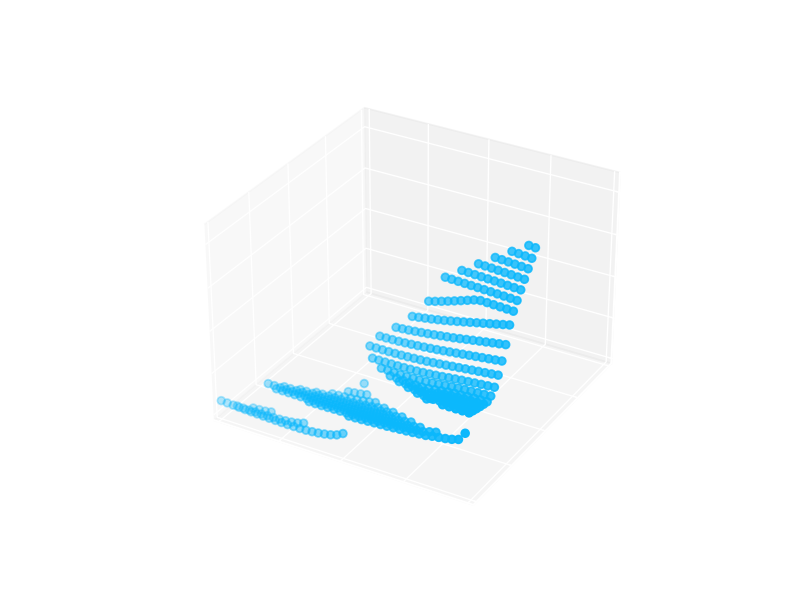

In [424]:
%matplotlib widget
#* Set model fit object
fit_object = model_fit_object_known

if fit_object.parameter_arr.squeeze().ndim==1:
    plt.ioff()
    params = np.array(fit_object.parameter_arr)
    loss = fit_object.loss_store
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(params, loss)
    ax.set_xlabel('Guess Delay')
    ax.set_ylabel('Loss')
    ax.set_ylim(0,6)
    plt.show()
else:
    plt.ion()
    params = np.array(fit_object.parameter_arr)
    loss = fit_object.loss_store
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(params[:,0], params[:,1], loss)
    ax.set_xlabel('Guess Delay')
    ax.set_ylabel('Guess SD')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 200)
    plt.show()

Plot movement onset vs guess delay

In [426]:
params.shape

(420,)

In [429]:
model_fit_object_known.leave_time_store.shape

(420, 6)

ValueError: x and y must be the same size

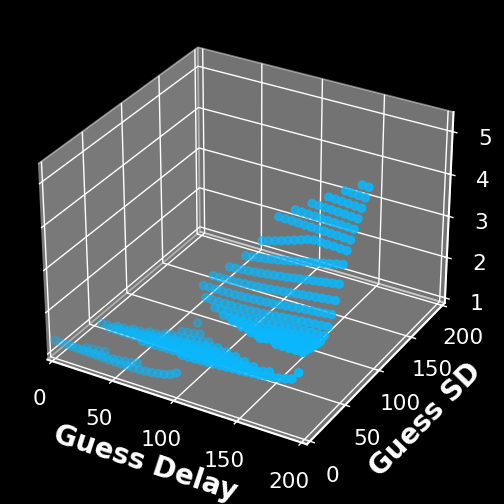

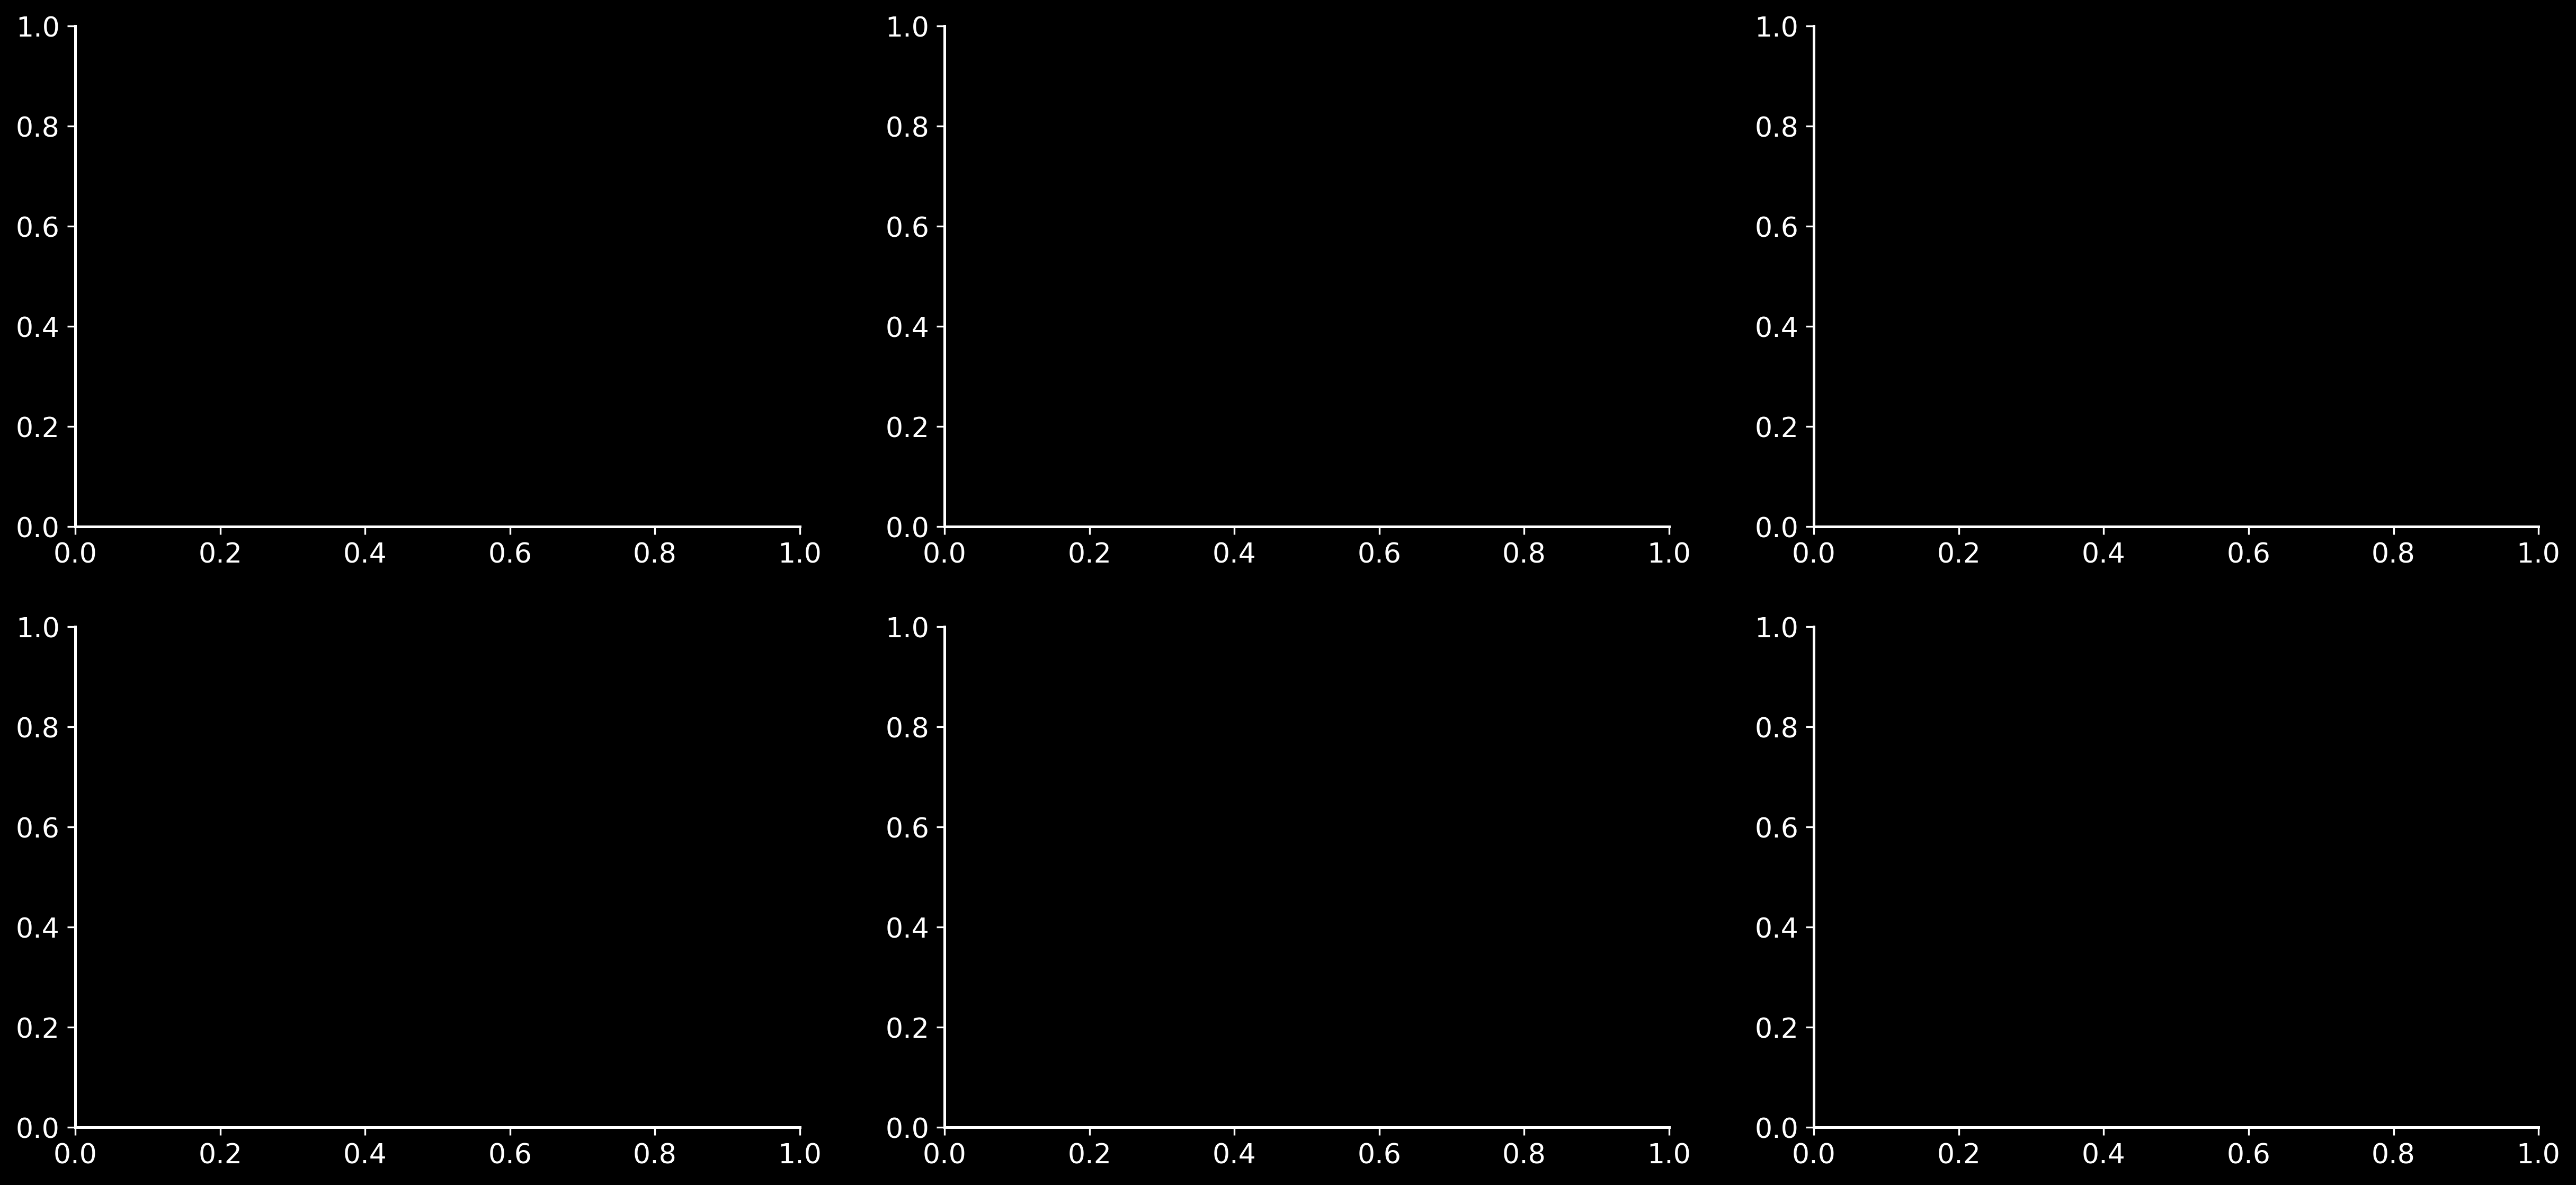

In [425]:
%matplotlib inline
yaxis_metric = model_fit_object_known.optimal_decision_time_store
params = np.array(model_fit_object_known.parameter_arr[:,0])
fig,axes = plt.subplots(2,3,figsize=(20,9),dpi=300)
for i,ax in enumerate(axes.flatten()):
    ax.scatter(params, yaxis_metric[:,i])
    if i == 0 or i == 3:
        ax.set_ylabel('Optimal Stopping Time (ms)')
    if i>2:
        ax.set_xlabel('Guess Switch Delay')
        
    ax.axhline(behavior_targets.flatten()[i])
    ax.axvline(model_known_switch.inputs.gamble_switch_delay['true'],c='grey')
    ax.set_yticks(np.arange(0,1600,250))
    ax.set_ylim(500,1600)
    if i == 4:
        ax.set_ylim(0,1600)
    ax.set_title(trial_block_titles[i])
    
plt.show()

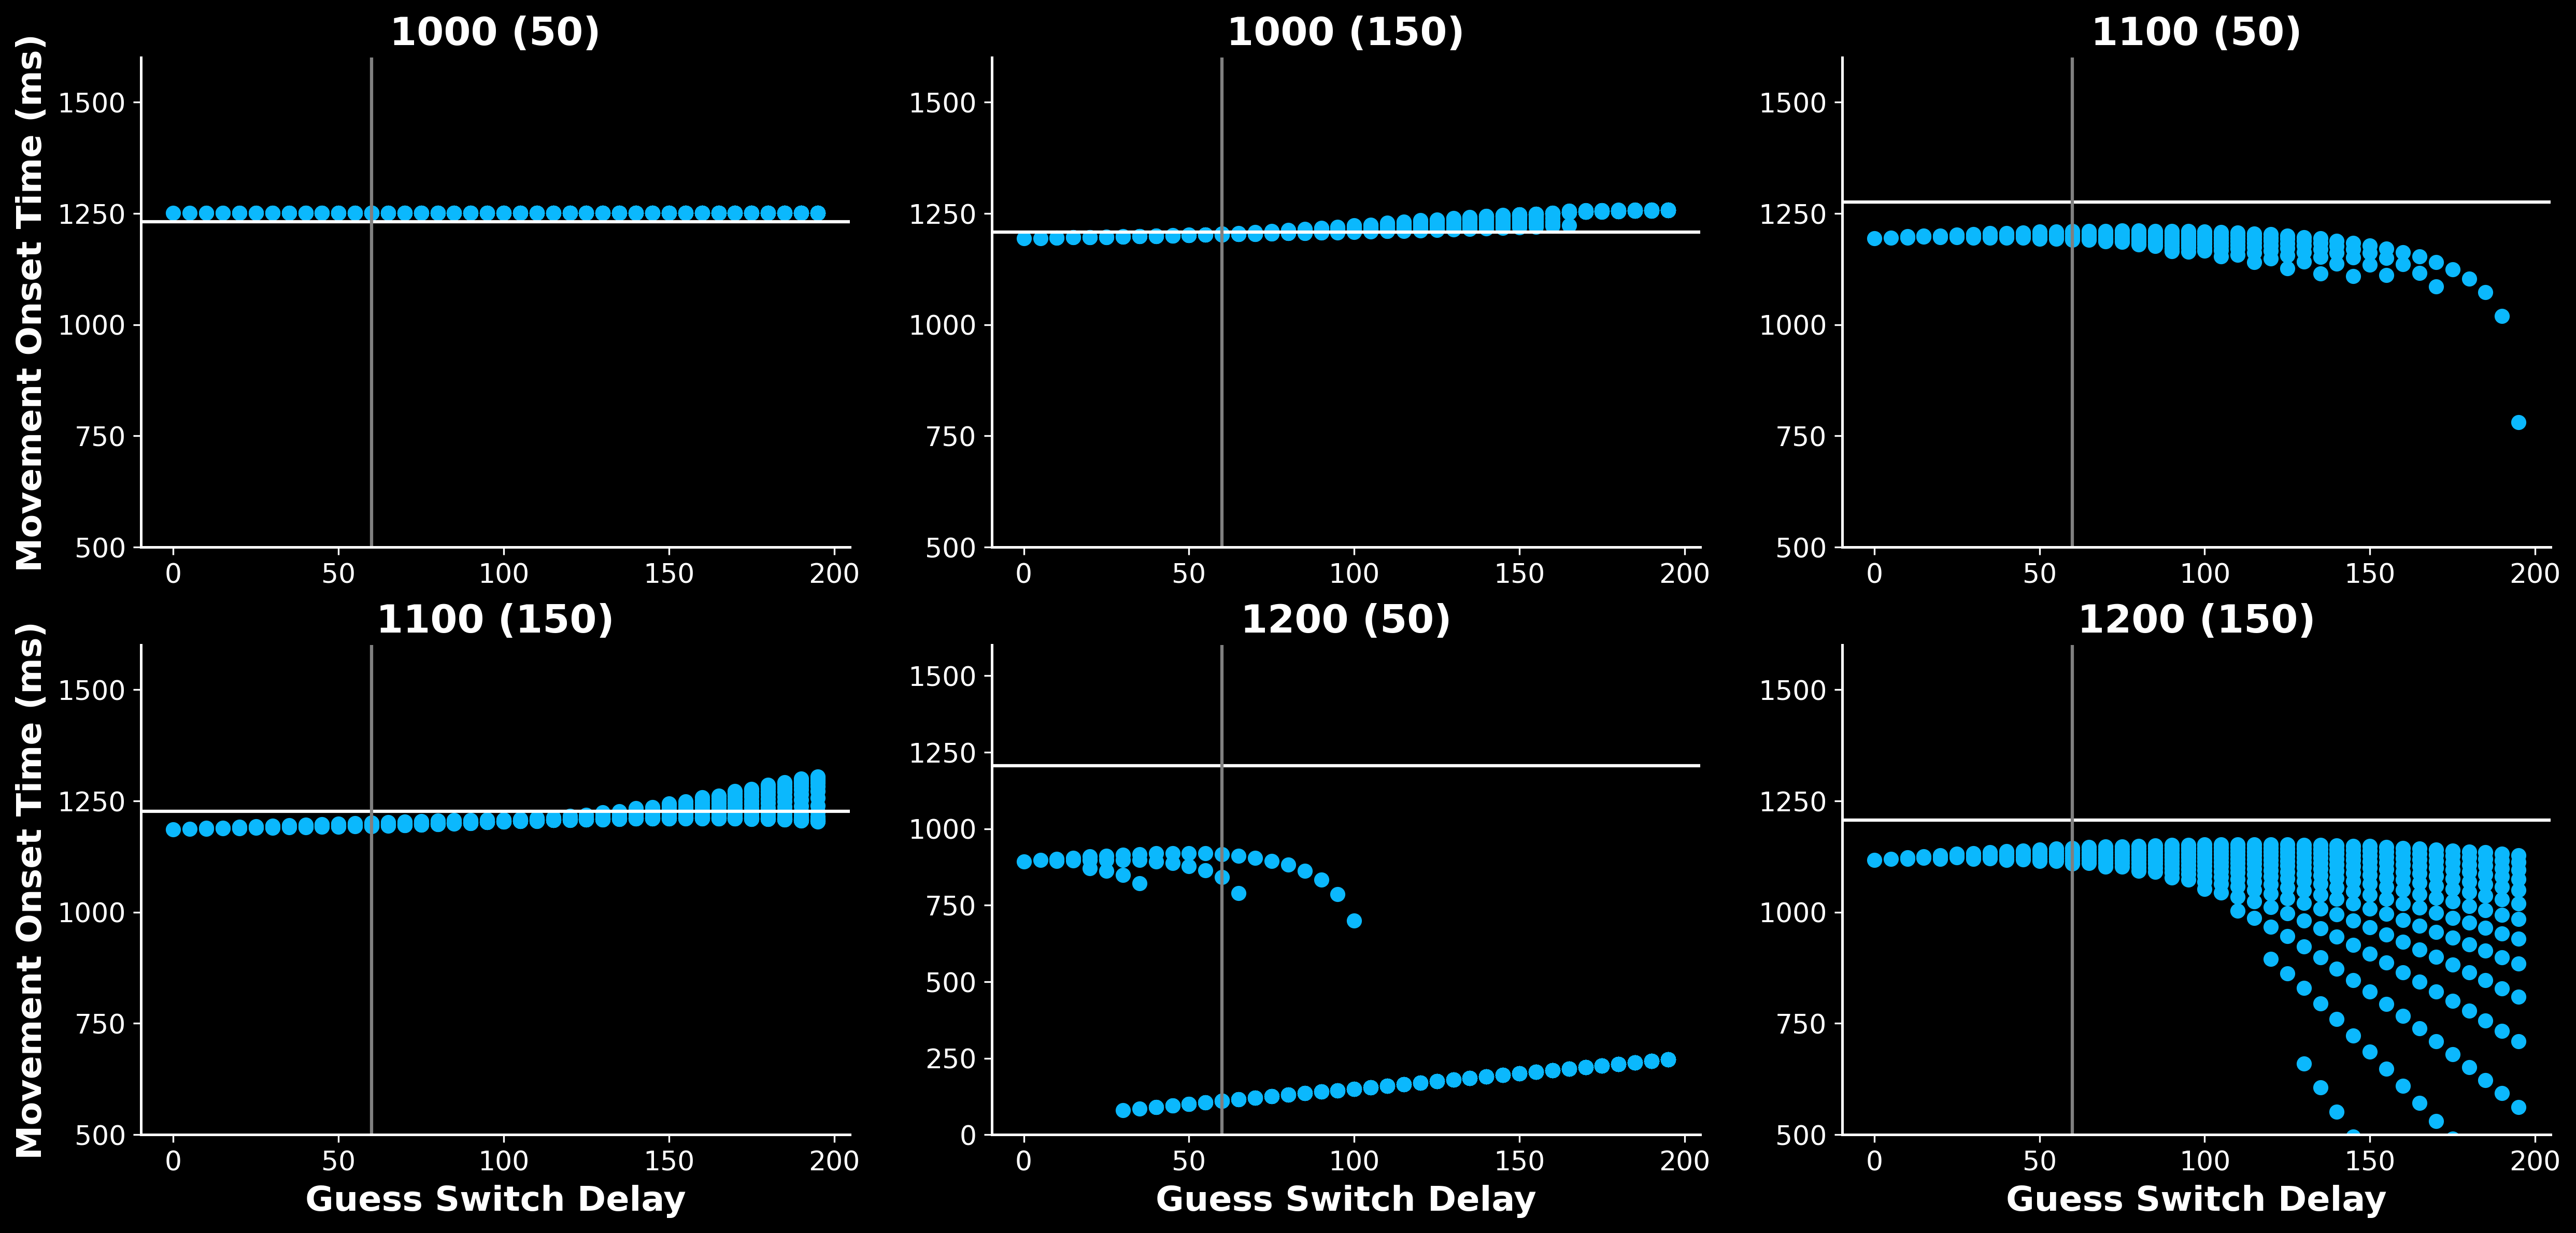

In [ ]:
%matplotlib inline
yaxis_metric = model_fit_object_known.leave_time_store
params = np.array(model_fit_object_known.parameter_arr[:,0])
fig,axes = plt.subplots(2,3,figsize=(20,9),dpi=300)
for i,ax in enumerate(axes.flatten()):
    ax.scatter(params, yaxis_metric[:,i])
    if i == 0 or i == 3:
        ax.set_ylabel('Movement Onset Time (ms)')
    if i>2:
        ax.set_xlabel('Guess Switch Delay')
        
    ax.axhline(behavior_targets.flatten()[i])
    ax.axvline(model_known_switch.inputs.gamble_switch_delay['true'],c='grey')
    ax.set_yticks(np.arange(0,1600,250))
    ax.set_ylim(500,1600)
    if i == 4:
        ax.set_ylim(0,1600)
    ax.set_title(trial_block_titles[i])
    
plt.show()

## Shorten the function names


In [ ]:
get_no_switch_metric = model_no_switch.results.get_metric
get_switch_metric = model_known_switch.results.get_metric
get_unknown_switch_metric = model_unknown_switch.results.get_metric
#! To get the value for not knowing the switch cost, you use the model_known_switch get_metric function with the model_unknown decision times 
example = get_no_switch_metric(model_known_switch.score_metrics.prob_indecision,metric_type='optimal')
example

array([0.085, 0.142, 0.192, 0.143, 0.001, 0.076])

# Plots


In [ ]:
save = False

In [ ]:
# optimal_model_full_knowledge.plot_optimals(metrics = ['exp_reward','prob_making_given_reaction','prob_indecision_given_reaction','prob_agent_has_gone'])#,'exp_reward_reaction','exp_reward_gamble','prob_selecting_reaction'])

Predicted Decision Time


In [ ]:
# group.predict_stopping_times(model_known_switch.inputs.gamble_delay["true"])
# metric = group.combine_all_subjects("player_stopping_times")
# no_switch_metric = model_no_switch.results.optimal_decision_time
# fit_switch_metric = model_known_switch.results.optimal_decision_time
# unknown_switch_metric = model_unknown_switch.results.optimal_decision_time
# w, h = 10, 6
# axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
# xlocs = np.linspace(0, w, num=len(trial_block_titles))
# ylocs = np.arange(900, 1600, 100)
# bw = 0.75
# pf.multiple_models_boxplot_v2(
#     ax=ax,
#     data=metric,
#     model_data_list=[no_switch_metric,fit_switch_metric, unknown_switch_metric],
#     labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
#     show_boxplot=True,
#     xlocs=xlocs,
#     box_width=bw,
#     colors=wheel.seth_blue,
#     linestyles=["-"] * 4,
#     remove_parentheses_from_labels=False,
# )

# ax.set_xticks(xlocs)
# ax.set_yticks(ylocs)
# ax.set_xticklabels(trial_block_titles)
# ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
# ax.set_ylim(min(ylocs), max(ylocs))

# ax.set_xlabel(xlabel)
# ax.set_ylabel("Time (ms)")
# ax.set_title("Predicted Decision Times")
# if save:
#     plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
# axmain.set_axis_off()
# plt.show()

AttributeError: 'SubjectBuilder' object has no attribute 'predict_stopping_times'

LEave Target Time


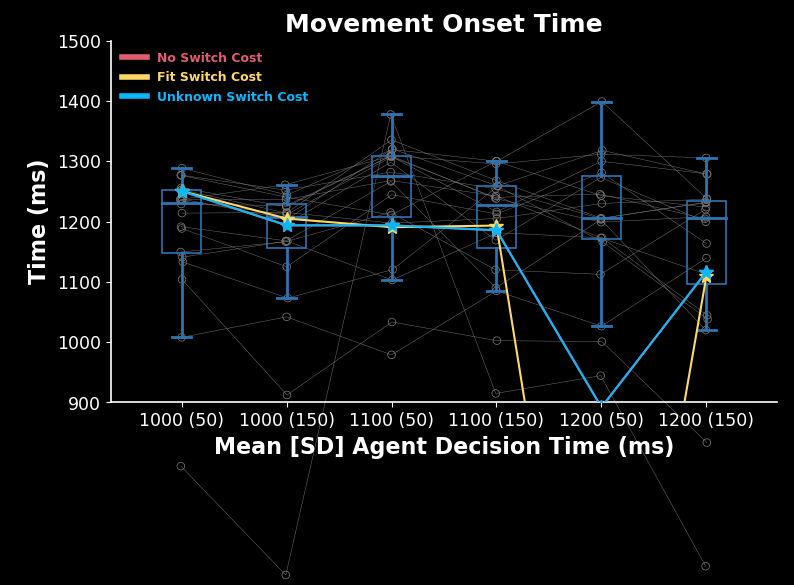

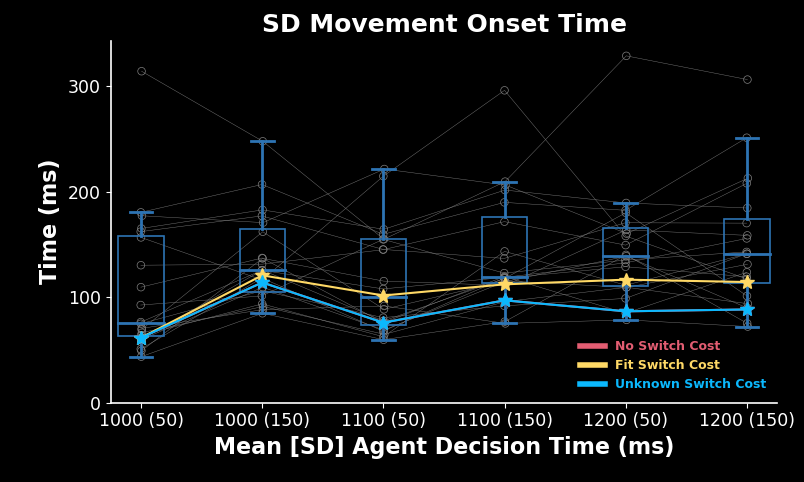

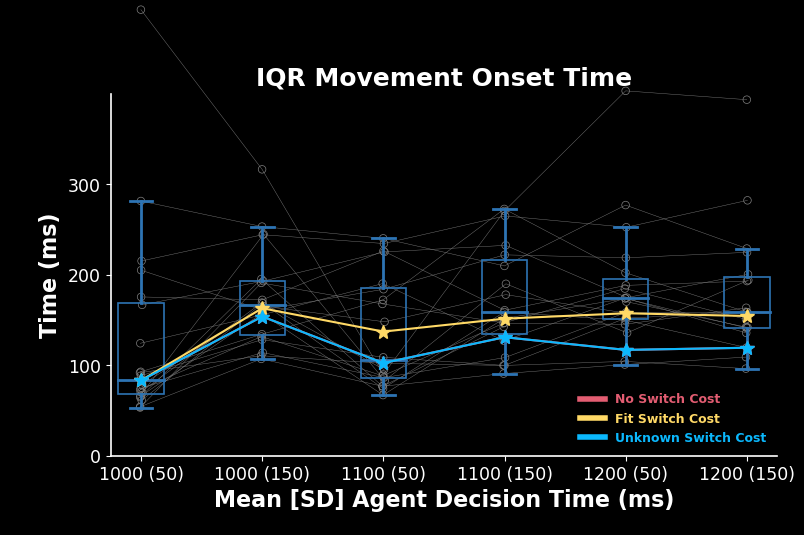

In [ ]:
metric = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
no_switch_metric = get_no_switch_metric(model_no_switch.player_behavior.wtd_leave_time,metric_type='optimal')
switch_metric = get_switch_metric(model_known_switch.player_behavior.wtd_leave_time,metric_type='optimal')
unknown_switch_metric = get_unknown_switch_metric(model_unknown_switch.player_behavior.wtd_leave_time,metric_type='optimal')
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[no_switch_metric,switch_metric, unknown_switch_metric],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("Movement Onset Time")
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

##########################################

metric = np.nanstd(group.movement_metrics.movement_onset_times('task'), axis=2)
no_switch_metric = get_no_switch_metric(model_no_switch.player_behavior.wtd_leave_time_sd,metric_type='optimal')
switch_metric = get_switch_metric(model_known_switch.player_behavior.wtd_leave_time_sd,metric_type='optimal')
unknown_switch_metric = get_unknown_switch_metric(model_unknown_switch.player_behavior.wtd_leave_time_sd,metric_type='optimal')

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 400, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[no_switch_metric, switch_metric, unknown_switch_metric],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("SD Movement Onset Time")
# ax.plot(xlocs,get_exp_metric(np.sqrt(model_unknown.player_behavior.gamble_reach_time_sd**2)))
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

###################################
metric = iqr(group.movement_metrics.movement_onset_times('task'), axis=2)
no_switch_metric = get_no_switch_metric(model_no_switch.player_behavior.wtd_leave_time_iqr,metric_type='optimal')
switch_metric = get_switch_metric(model_known_switch.player_behavior.wtd_leave_time_iqr,metric_type='optimal')
unknown_switch_metric = get_unknown_switch_metric(model_unknown_switch.player_behavior.wtd_leave_time_iqr,metric_type='optimal')

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 400, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[no_switch_metric, switch_metric, unknown_switch_metric],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("IQR Movement Onset Time")
ax.set_ylim(0,400)
# ax.plot(xlocs,get_exp_metric(np.sqrt(model_unknown.player_behavior.gamble_reach_time_sd**2)))
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

Wins


In [ ]:
metric = perc(group.score_metrics.score_metric('wins'))
no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.prob_win,metric_type='optimal')*100
switch_metric = get_switch_metric(model_known_switch.score_metrics.prob_win,metric_type='optimal')*100
unknown_switch_metric = get_unknown_switch_metric(model_unknown_switch.score_metrics.prob_win,metric_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[no_switch_metric, switch_metric, unknown_switch_metric],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Wins (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "wins_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

NameError: name 'perc' is not defined

Points


In [ ]:
model_unknown_switch.inputs.gamble_switch_delay

{'true': 0.0, 'exp': 0}

In [ ]:
if experiment == "Exp2":
    metric = group.player_points_scored
    true_player_metric = get_true_metric(model_known_switch.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    exp_player_metric = get_exp_metric(model_unknown.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    true_optimal_metric = get_true_metric(model_known_switch.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    exp_optimal_metric = get_exp_metric(model_known_switch.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(trial_block_titles))
    ylocs = np.arange(0, 125, 20)

    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        true_player=true_player_metric,
        expected_player=exp_player_metric,
        true_optimal=true_optimal_metric,
        expected_optimal=exp_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.seth_blue,
        remove_parentheses_from_labels=False,
    )

    ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(trial_block_titles)
    ax.set_ylim(-20, 80)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Points Scored")
    # dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
    axmain.set_axis_off()

    plt.show()

Incorrects


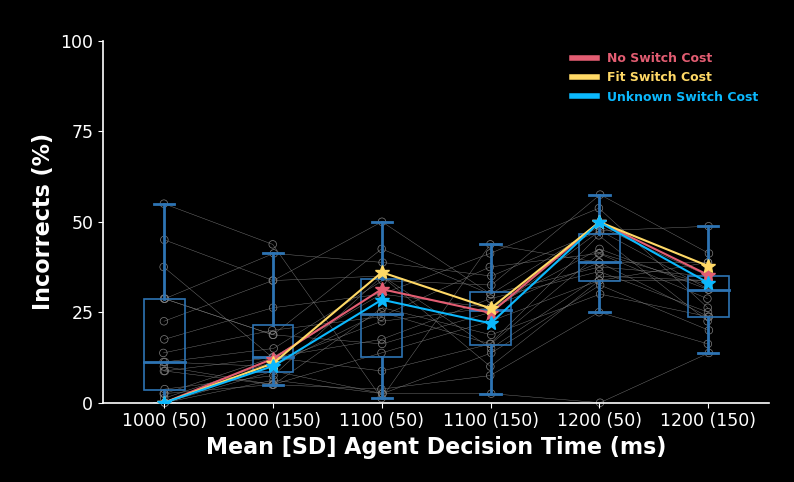

In [ ]:
metric = group.player_perc_incorrects
no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.prob_incorrect,metric_type='optimal')*100
switch_metric = get_switch_metric(model_known_switch.score_metrics.prob_incorrect,metric_type='optimal')*100
unknown_switch_metric = get_unknown_switch_metric(model_unknown_switch.score_metrics.prob_incorrect,metric_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[no_switch_metric, switch_metric, unknown_switch_metric],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Incorrects (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Indecisions


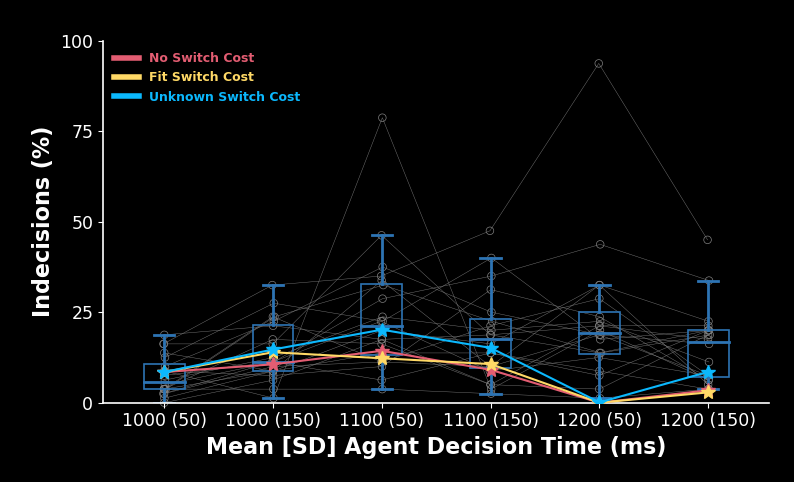

In [ ]:
metric = group.player_perc_indecisions
no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.prob_indecision,metric_type='optimal')*100
switch_metric = get_switch_metric(model_known_switch.score_metrics.prob_indecision,metric_type='optimal')*100
unknown_switch_metric = get_unknown_switch_metric(model_unknown_switch.score_metrics.prob_indecision,metric_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[no_switch_metric, switch_metric, unknown_switch_metric],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Indecisions (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "indecisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Wins, Incorrects, Indecisions on One plot


Correct Initial Decisions


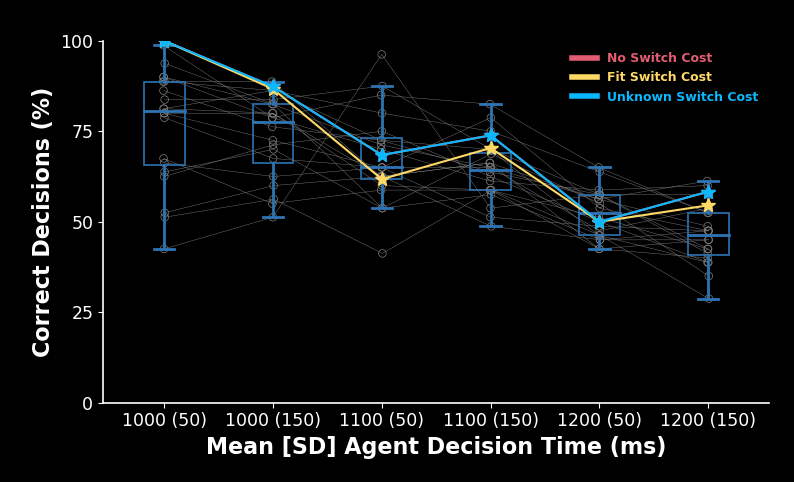

In [ ]:
metric = group.phat_correct * 100
no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.correct_decisions,metric_type='optimal')*100
switch_metric = get_switch_metric(model_known_switch.score_metrics.correct_decisions,metric_type='optimal')*100
unknown_switch_metric = get_unknown_switch_metric(model_unknown_switch.score_metrics.correct_decisions,metric_type='optimal')*100
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[no_switch_metric, switch_metric, unknown_switch_metric],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Correct Decisions (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "correct_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Decisions


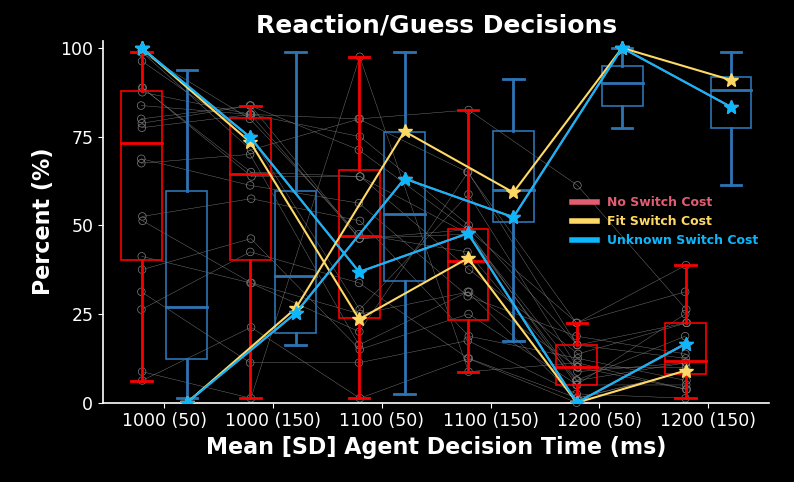

In [ ]:
data_metric1 = group.combine_all_subjects("perc_reaction_decisions")
no_switch_metric1 = get_no_switch_metric(model_no_switch.player_behavior.prob_selecting_reaction, metric_type="optimal") * 100
switch_metric1 = get_switch_metric(model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal") * 100
unknown_switch_metric1 = get_no_switch_metric(model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal") * 100

data_metric2 = group.combine_all_subjects("perc_gamble_decisions")
no_switch_metric2 = get_no_switch_metric(model_no_switch.player_behavior.prob_selecting_gamble, metric_type="optimal") * 100
switch_metric2 = get_switch_metric(model_known_switch.player_behavior.prob_selecting_gamble, metric_type="optimal") * 100
unknown_switch_metric2 = get_no_switch_metric(model_known_switch.player_behavior.prob_selecting_gamble, metric_type="optimal") * 100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess Decisions")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Leave Times


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


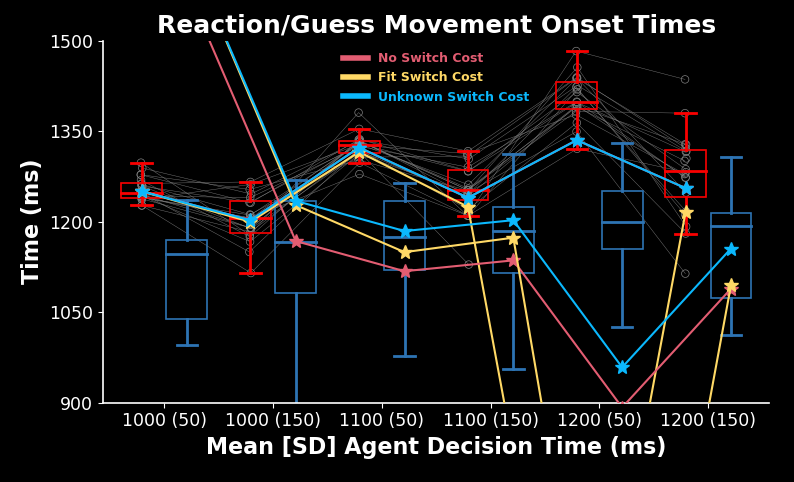

In [ ]:
data_metric1 = np.nanmedian(group.player_reaction_task_leave_time, axis=2)
data_metric2 = np.nanmedian(group.player_gamble_task_leave_time, axis=2)

no_switch_metric1 = get_no_switch_metric(model_no_switch.player_behavior.reaction_leave_time, metric_type="optimal")
switch_metric1 = get_switch_metric(model_known_switch.player_behavior.reaction_leave_time, metric_type="optimal")
unknown_switch_metric1 = get_no_switch_metric(model_known_switch.player_behavior.reaction_leave_time, metric_type="optimal")

no_switch_metric2 = get_no_switch_metric(model_no_switch.player_behavior.gamble_leave_time, metric_type="optimal")
switch_metric2 = get_switch_metric(model_known_switch.player_behavior.gamble_leave_time, metric_type="optimal")
unknown_switch_metric2 = get_no_switch_metric(model_known_switch.player_behavior.gamble_leave_time, metric_type="optimal")

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1650, 150)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess Movement Onset Times")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Guess Movement Onset Times


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


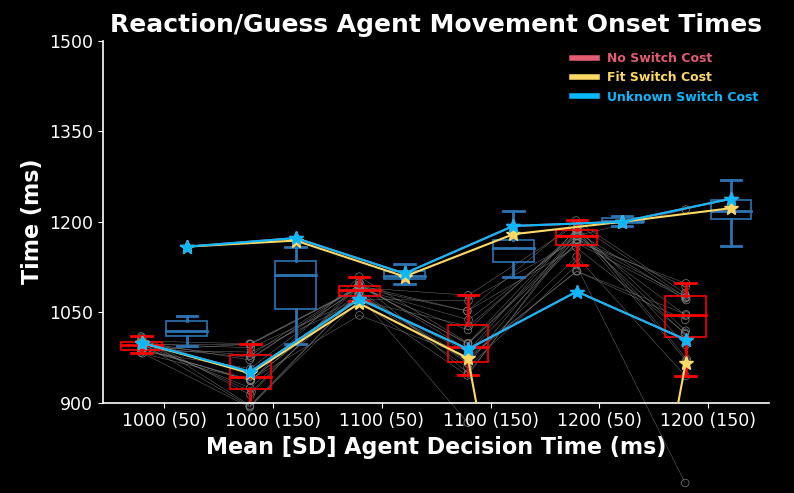

In [ ]:
data_metric1 = np.nanmedian(group.agent_reaction_task_leave_time, axis=2)
data_metric2 = np.nanmedian(group.agent_gamble_task_leave_time, axis=2)

no_switch_metric1 = get_no_switch_metric(model_no_switch.agent_behavior.reaction_leave_time, metric_type="optimal")
switch_metric1 = get_switch_metric(model_known_switch.agent_behavior.reaction_leave_time, metric_type="optimal")
unknown_switch_metric1 = get_no_switch_metric(model_known_switch.agent_behavior.reaction_leave_time, metric_type="optimal")

no_switch_metric2 = get_no_switch_metric(model_no_switch.agent_behavior.gamble_leave_time, metric_type="optimal")
switch_metric2 = get_switch_metric(model_known_switch.agent_behavior.gamble_leave_time, metric_type="optimal")
unknown_switch_metric2 = get_no_switch_metric(model_known_switch.agent_behavior.gamble_leave_time, metric_type="optimal")

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1650, 150)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess Agent Movement Onset Times")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Wins That Were Reaction and Gamble

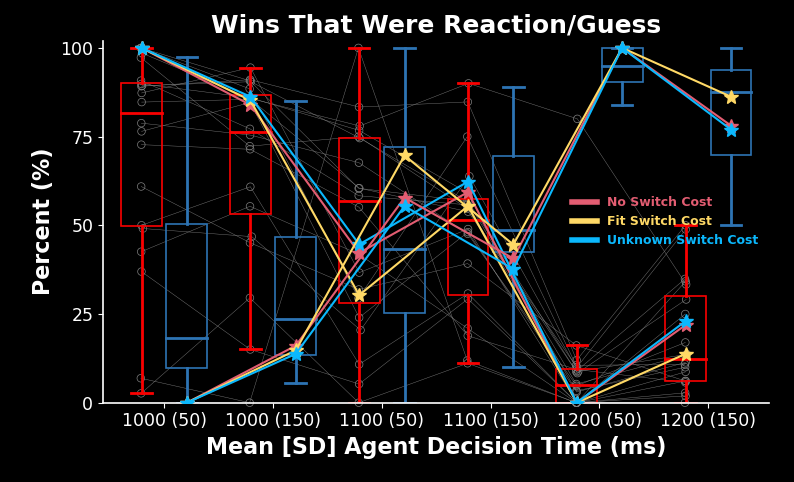

In [ ]:
# Out of x number of wins, how many were Reaction and Guess
data_metric1 = group.perc_wins_that_were_reactions
data_metric2 = group.perc_wins_that_were_gambles

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_win_reaction, 
    model_no_switch.score_metrics.prob_win, metric_type="optimal"
) * 100
switch_metric1 = get_switch_metric(
    model_known_switch.score_metrics.prob_win_reaction, 
    model_known_switch.score_metrics.prob_win, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_win_reaction, 
    model_known_switch.score_metrics.prob_win, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_win_gamble, 
    model_no_switch.score_metrics.prob_win, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_known_switch.score_metrics.prob_win_gamble, 
    model_known_switch.score_metrics.prob_win, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_win_gamble, 
    model_known_switch.score_metrics.prob_win, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Wins That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Incorrects that were Reaction and Guess


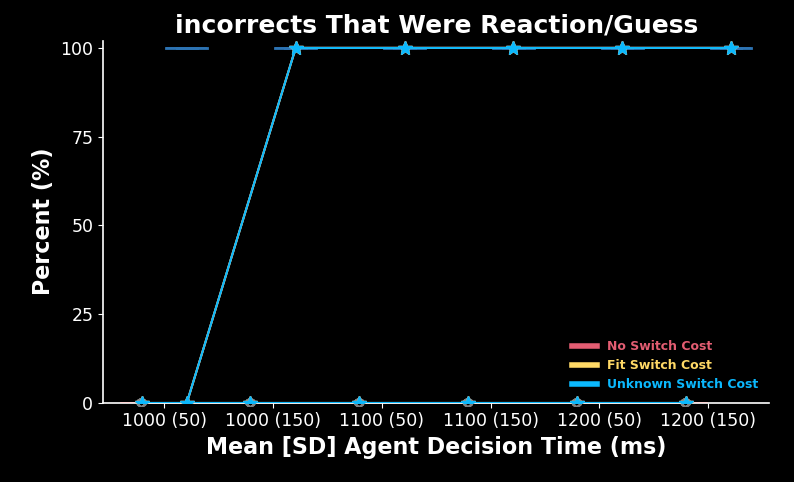

In [ ]:
# Out of x number of incorrects, how many were Reaction and Guess
data_metric1 = group.perc_incorrects_that_were_reactions
data_metric2 = group.perc_incorrects_that_were_gambles

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_incorrect_reaction, 
    model_no_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
switch_metric1 = get_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_reaction, 
    model_known_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_reaction, 
    model_known_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_incorrect_gamble, 
    model_no_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_gamble, 
    model_known_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_gamble, 
    model_known_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("incorrects That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Reaction/Gamble


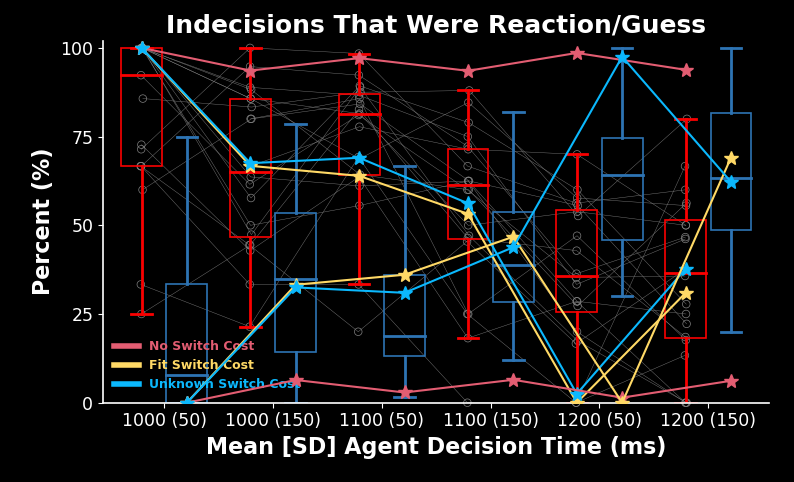

In [ ]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.perc_indecisions_that_were_reactions
data_metric2 = group.perc_indecisions_that_were_gambles

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_indecision_reaction, 
    model_no_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
switch_metric1 = get_switch_metric(
    model_known_switch.score_metrics.prob_indecision_reaction, 
    model_known_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_indecision_reaction, 
    model_known_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_indecision_gamble, 
    model_no_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_known_switch.score_metrics.prob_indecision_gamble, 
    model_known_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_indecision_gamble, 
    model_known_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Indecisions That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

OUt of the Reaction/Gamble How many times did they win


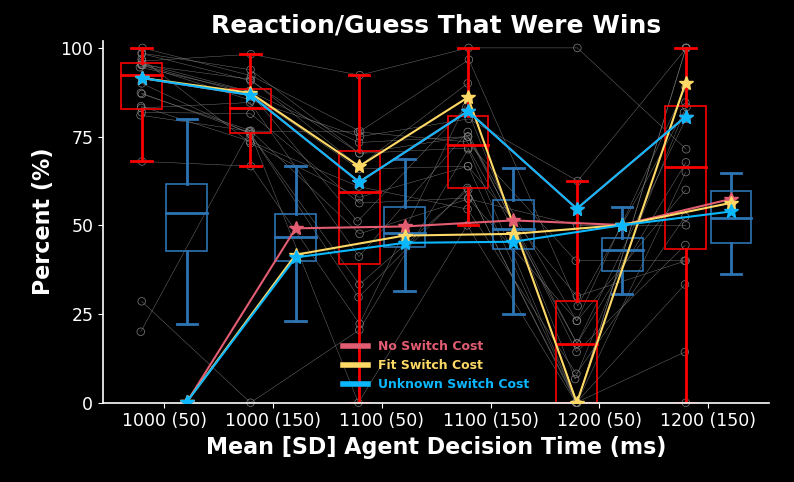

In [ ]:
#
# * Out of x number of reactions/gambles, how many were wins
data_metric1 = group.perc_reactions_that_were_wins
data_metric2 = group.perc_gambles_that_were_wins

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_win_reaction, 
    model_no_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
switch_metric1 = get_switch_metric(
    model_known_switch.score_metrics.prob_win_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_win_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_win_gamble, 
    model_no_switch.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_known_switch.score_metrics.prob_win_gamble, 
    model_known_switch.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_win_gamble, 
    model_known_switch.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess That Were Wins")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Reaction and Guess That Were Incorrects


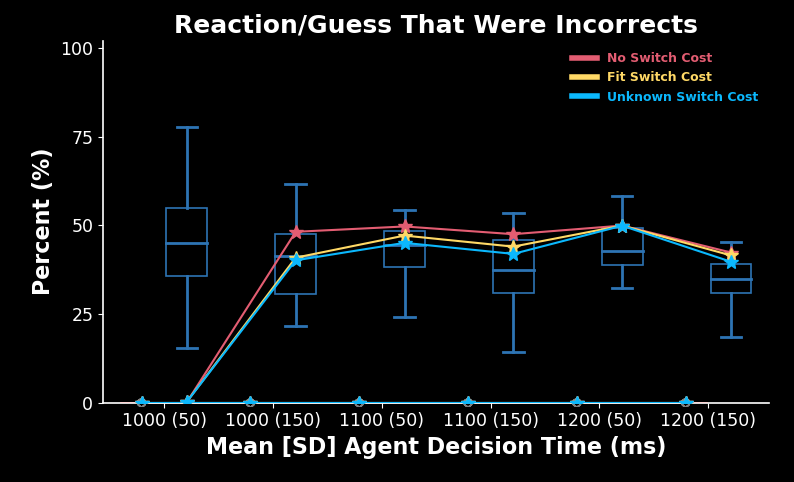

In [ ]:
#
# * Out of x number of reactions/gambles, how many were incorrects
data_metric1 = group.perc_reactions_that_were_incorrects
data_metric2 = group.perc_gambles_that_were_incorrects

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_incorrect_reaction, 
    model_no_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
switch_metric1 = get_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_incorrect_gamble, 
    model_no_switch.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_gamble, 
    model_known_switch.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_gamble, 
    model_known_switch.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess That Were Incorrects")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

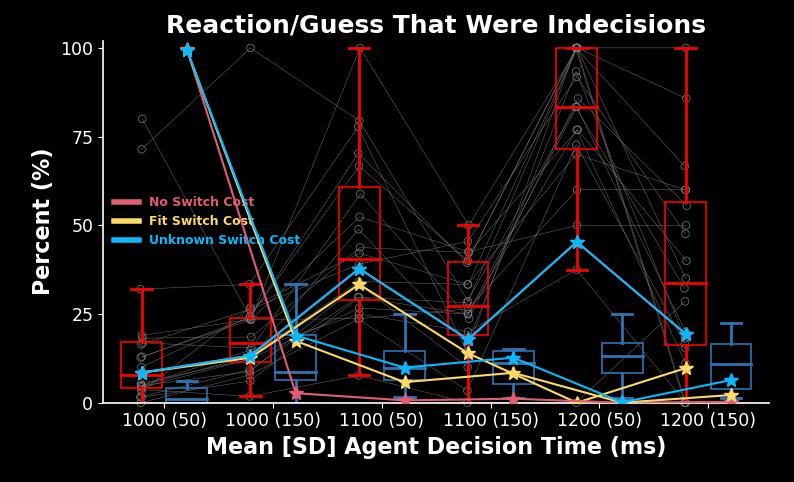

In [ ]:
#
# * Out of x number of reactions/gambles, how many were indecisions
data_metric1 = group.perc_reactions_that_were_indecisions
data_metric2 = group.perc_gambles_that_were_indecisions

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_indecision_reaction, 
    model_no_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
switch_metric1 = get_switch_metric(
    model_known_switch.score_metrics.prob_indecision_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_indecision_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_indecision_gamble, 
    model_no_switch.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_known_switch.score_metrics.prob_indecision_gamble, 
    model_known_switch.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_indecision_gamble, 
    model_known_switch.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Fit Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess That Were Indecisions")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()